In [13]:
import rpy2.robjects as robjects
import numpy as np
from irf.ensemble import wrf
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from irf import irf_utils, irf_jupyter_utils
from rfms.storytellers import test_feature_importance, oob_feature_importance

In [2]:
#Read data from R and transform to python object
tmp = robjects.r['load']('./iRF_analyses/data/enhancer.Rdata')
print(tmp)
X = robjects.r["X"]
XX = np.asarray(X)
print(XX)
assert(len(XX[0]) == X.ncol) #same number of cols
assert(len(XX) == X.nrow)
X = XX
Y = robjects.r["Y"]
Y = np.asarray(Y)
assert(len(Y) == len(X))
test = np.asarray(robjects.r["test.id"])
print(test)
train = np.asarray(robjects.r["train.id"])
varnames = np.asarray(robjects.r["varnames.all"])
print(varnames)

[1] "X"            "Y"            "test.id"      "train.id"     "varnames.all"

[[ 6.      10.      10.      ...  0.       0.       0.     ]
 [ 6.       7.       6.      ...  0.       0.       0.     ]
 [14.       9.      14.      ...  0.       0.       1.2013 ]
 ...
 [ 9.      12.      16.      ...  2.13176  2.22051  1.20134]
 [17.      18.      14.      ...  1.49709  1.39971  1.26398]
 [13.      15.      18.      ...  2.03769  2.03994  0.     ]]
[   1    5    7 ... 7804 7808 7809]
[['H3_c12' 'H3_c14a' 'H3_c14c' 'H3_c8' 'H3K18ac_c12' 'H3K18ac_c14a'
  'H3K18ac_c14c' 'H3K18ac_c8' 'H3K27ac_c12' 'H3K27ac_c14a' 'H3K27ac_c14c'
  'H3K27ac_c8' 'H3K27me3_c12' 'H3K27me3_c14a' 'H3K27me3_c14c'
  'H3K36me3_c12' 'H3K36me3_c14a' 'H3K36me3_c14c' 'H3K4me1_c12'
  'H3K4me1_c14a' 'H3K4me1_c14c' 'H3K4me1_c8' 'H3K4me3_c12' 'H3K4me3_c14a'
  'H3K4me3_c14c' 'H3K4me3_c8' 'H3K9ac_c12' 'H3K9ac_c14a' 'H3K9ac_c14c'
  'H3K9ac_c8' 'H4K5ac_c12' 'H4K5ac_c14a' 'H4K5ac_c14c' 'H4K5ac_c8'
  'H4K8ac_c12' 'H4K8ac_c14a' 'H4K

In [3]:
# split train test set
X_train = X[train-1,:]
X_test = X[test-1,:]
y_train = Y[train - 1]
y_test = Y[test - 1]

In [ ]:
#load irf package and output result
my_wrf = wrf(n_estimators=100, max_depth=5)
my_wrf.fit(X = X_train, y = y_train, K = 4)
"""
all_rf_weights, all_K_iter_rf_data, \
    all_rf_bootstrap_output, all_rit_bootstrap_output, \
    stability_score = irf_utils.run_iRF(X_train=X_train,
                                        X_test=X_test,
                                        y_train=y_train,
                                        y_test=y_test,
                                        K=5,                          # number of iteration
                                        n_estimators=500,              # number of trees in the forest
                                        B=30,
                                        random_state_classifier=2018, # random seed
                                        propn_n_samples=.2,
                                        bin_class_type=1,
                                        M=20,
                                        max_depth=5,
                                        noisy_split=False,
                                        num_splits=2,
                                        n_estimators_bootstrap=5)
"""


In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5)

In [46]:
oob_importance = oob_feature_importance(my_wrf, X_train, y_train)
test_importance = test_feature_importance(my_wrf, X_test, y_test)

KeyboardInterrupt: 

In [ ]:
plt.scatter(x = my_wrf.feature_importances_, y = test_importance)
plt.scatter(x = oob_importance, y = test_importance)
plt.plot([min(test_importance), max(test_importance)], [min(test_importance), max(test_importance)])

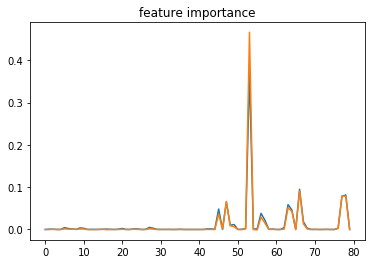

In [39]:
plt.plot(my_wrf.feature_importances_)
plt.plot(oob_importance)
plt.title('feature importance')
plt.show()

## look at most important features

In [7]:
varnames[1][np.argsort(my_wrf.feature_importances_ * -1)[:5]], np.argsort(my_wrf.feature_importances_ * -1)[:5]

(array(['gt2', 'twi', 'wt_ZLD', 'kr', 'twi'], dtype='<U13'),
 array([53, 78, 45, 63, 77]))

In [14]:
boost = AdaBoostClassifier(base_estimator=wrf(n_estimators=100), 
                           n_estimators=5, 
                           learning_rate=1.0, 
                           algorithm='SAMME.R', 
                           random_state=None)
boost.fit(X = X_train, y = y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=wrf(bootstrap=True, class_weight=None, criterion='gini', max_depth=None,
  max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
  min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
  min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
  oob_score=False, random_state=None, verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=5, random_state=None)

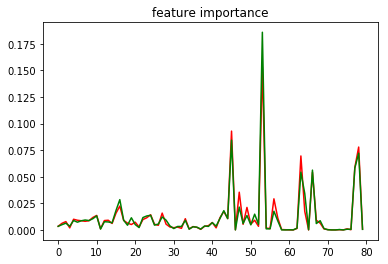

In [15]:
xs = range(len(X[0]))
plt.plot(xs, boost.estimators_[0].feature_importances_,'r-',
#         xs, boost.estimators_[1].feature_importances_,'r-.',
#         xs, boost.estimators_[2].feature_importances_,'b-',
#         xs, boost.estimators_[3].feature_importances_,'b-.',
         xs, boost.estimators_[4].feature_importances_,'g')
plt.title('feature importance')
plt.show()

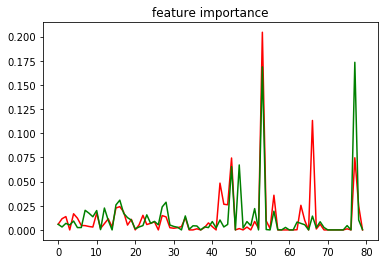

In [29]:
#TODO: get higher order feature combinations
for b in range(B):
    # Take a bootstrap sample from the training data
    # based on the specified user proportion
    X_train_rsmpl, y_rsmpl = resample(
        X_train, y_train, n_samples=n_samples)
    # Set up the weighted random forest
    # Using the weight from the (K-1)th iteration i.e. RF(w(K))
    rf_bootstrap = RandomForestClassifier(
    # CHECK: different number of trees to fit for bootstrap samples
    n_estimators=n_estimators_bootstrap)
    # Fit RF(w(K)) on the bootstrapped dataset
    rf_bootstrap.fit(
        X=X_train_rsmpl,
        y=y_rsmpl,
        feature_weight=all_rf_weights["rf_weight{}".format(K)])

    # All RF tree data
    # CHECK: why do we need y_train here?
    all_rf_tree_data = get_rf_tree_data(
        rf=rf_bootstrap,
        X_train=X_train_rsmpl,
        X_test=X_test,
        y_test=y_test)

    # Update the rf bootstrap output dictionary
    all_rf_bootstrap_output['rf_bootstrap{}'.format(b)] = all_rf_tree_data

    # Run RIT on the interaction rule set
    # CHECK - each of these variables needs to be passed into
    # the main run_rit function
    all_rit_tree_data = get_rit_tree_data(
        all_rf_tree_data=all_rf_tree_data,
        bin_class_type=bin_class_type,
        M=M,
        max_depth=max_depth,
        noisy_split=noisy_split,
        num_splits=num_splits)

    # Update the rf bootstrap output dictionary
    # We will reference the RIT for a particular rf bootstrap
    # using the specific bootstrap id - consistent with the
    # rf bootstrap output data
    all_rit_bootstrap_output['rf_bootstrap{}'.format(
        b)] = all_rit_tree_data

    stability_score = _get_stability_score(
        all_rit_bootstrap_output=all_rit_bootstrap_output)

# load embryo data

In [48]:
import scipy.io as spio
import numpy as np
np.set_printoptions(threshold=100)
mat = spio.loadmat('embryo.mat')

In [53]:
data = mat['X']
print(data)
gene = mat['geneNames']
print(gene.shape)
print([str(a) for a in gene[0]])

[[ 0.01412348  0.05531271  0.01402325 ...,  0.10028901  0.22399545
  -0.00673914]
 [ 0.00901597  0.01234864  0.00851458 ...,  0.17167943  0.25330816
   0.04216224]
 [ 0.02304726  0.01486692  0.00623291 ...,  0.11848573  0.18323936
   0.07947944]
 ..., 
 [ 0.03909715  0.12814427  0.13263424 ...,  0.04773932  0.04581725
   0.37317126]
 [ 0.02099263  0.10569478  0.06146273 ...,  0.04628919  0.0607134
   0.32291272]
 [ 0.00961777  0.07235746  0.07636401 ...,  0.01066792  0.01534763
   0.16441483]]
(1, 1640)
["['pnr']", "['CG11648']", "['CG11648']", "['CG10645']", "['CG10645']", "['Mkp3']", "['Mkp3']", "['CG9739']", "['CG6464']", "['CG6464']", "['CG6464']", "['CG6464']", "['CG6464']", "['CG4717']", "['CG4717']", "['CG4717']", "['CG8896']", "['CG8896']", "['CG8896']", "['CG8896']", "['CG33158']", "['CG4199']", "['CG7800']", "['CG7800']", "['CG7800']", "['CG7800']", "['CG1772']", "['CG1772']", "['CG1772']", "['CG1772']", "['CG1772']", "['retn']", "['retn']", "['retn']", "['CG1829']", "['CG182